# Rheostat-like variation in functional gene expression

* We annotated the top genes with the highest loadings and correlations ($\rho > 0.25$) for GEP$_{High}$ and GEP$_{Low}$ for known functional and neuronal categories. 
* 63 and 54 "neuronal" genes whose known or proposed function in neurons were identified for the two ES GEPs. As listed in [Table S3](../data/tables/GSE173947_Table_S3_ES_neuronal_genes.csv), these neuronal genes were categorized according to their putative roles in either calcium homeostasis (calcium binding, calcium signaling, inositol phosphatide related) ion transfer (ion channel, ion pump/transporter), axon guidance (axon guidance, cell adhesion), synapse (synapse, secretory peptide), or protein transport (ER/Golgi/cilia related). 
* The remaining genes with high loadings and correlations with the ES GEPs had similar patterns of gene expression in OSNs as the above genes, but their functions in OSNs remain unannotated. 
* The "neuronal" genes were further restricted to include only the "functional" gene categories that are predicted to directly impact OSN odor responses, and which included the 73 genes that were part of the calcium homeostasis, ion transfer and OR signaling categories 

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scanpy as sc
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cmocean

from osn.nmf import nmf
from osn.olfr import olfr
from osn.preprocess import get_data_folders
from osn.viz import viz

In [3]:
sns.set_context("notebook")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load home-cage adata

In [4]:
data_fold = get_data_folders()
ad_fn = data_fold.processed / "home_cage_norm.h5ad"
adata = sc.read(ad_fn)
print(adata)

AnnData object with n_obs × n_vars = 38345 × 30681
    obs: 'top_Olfr', 'source', 'orig_ident', 'ES_score', 'UMAP_1', 'UMAP_2', 'round2', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts', 'OR_counts', 'OR_counts_norm'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf', 'X_umap'


##  subselect ORs expressed in enough cells 

In [5]:
# find which cells express Olfrs in enough cells
SOURCE_THRESH = 10
df_OR, has_OR = olfr.get_OR_info(adata)
uq_olfr, has_enough_ORs = olfr.filter_OR_source(df_OR, SOURCE_THRESH)
n_OR = len(uq_olfr)
df_OR_keep = df_OR[has_enough_ORs]
print(f"Found {n_OR} ORs with at least {SOURCE_THRESH} cells per OR; keeping {len(df_OR_keep)} OSNs")
# get numerical labels of the OR expressed in each cell (0-830, corresponding to each of the 831 ORs in `uq_olfr`)
or_num = LabelEncoder().fit_transform(df_OR_keep.top_Olfr)
# take mean across OSNs expressing each OR
df_mean = df_OR_keep.groupby('top_Olfr').mean()
in_baseline_keep = adata.obs_names.isin(df_OR_keep.index)
assert adata.obs_names[in_baseline_keep].equals(df_OR_keep.index)

Found 831 ORs with at least 10 cells per OR; keeping 37441 OSNs


## load functional genes 

In [6]:
df_func_genes, cats = nmf.load_func_genes()
assert df_func_genes.index.isin(adata.var_names).all()
is_func_gene = adata.var_names.isin(df_func_genes.index)
func_gene_keep = adata.var_names[is_func_gene]
df_func_keep = df_func_genes.loc[func_gene_keep]
geps = np.unique(df_func_keep.gep)
n_func_genes = len(func_gene_keep)
df_func_pred = df_func_genes[df_func_genes.is_func]
pred_genes = df_func_pred.index
print(
    f"Found {len(func_gene_keep)} neuronal genes and {len(pred_genes)} functional genes"
)
df_func_pred.head()

Found 117 neuronal genes and 73 functional genes


,gep,cat1,cat2,func,is_func
Pcp4l1,high,calcium,calcium binding,YES,True
S100a5,high,calcium,calcium binding,YES,True
Rasgrp4,high,calcium,calcium binding,YES,True
Snca,high,calcium,calcium binding,YES,True
Hpcal1,high,calcium,calcium binding,YES,True


# Plots depicting relationships between functional genes, OSN subtypes, and associated GEPs
* Summarize GEP usage, ES scores, and gene expression at the OR-level for each OSN subtype

In [7]:
# mean of each gene for each OR
X_func = adata.X[in_baseline_keep][:, is_func_gene].A
X_mean = npg.aggregate(or_num, X_func, func="mean", axis=0)
df_func_mean = pd.DataFrame(X_mean, index=uq_olfr, columns=func_gene_keep)
print(df_func_mean.shape)
func_corr = stats.spearmanr(X_mean, df_mean.ES_score).correlation[:-1, -1]
df_func_keep['corr'] = func_corr
df_func_keep['abs_corr'] = np.abs(func_corr)

(831, 117)


In [8]:
# sort by correlation for each gep/category
corr_order = np.argsort(np.argsort(func_corr)[::-1])
orders = []
for gep in geps:
    is_gep = df_func_keep.gep == gep
    for cat in cats:
        is_cat = df_func_keep.cat1 == cat
        is_subset = np.where((is_gep) & (is_cat))[0]
        orders.append(is_subset[np.argsort(corr_order[is_subset])])
orders = np.hstack(orders)
func_order = func_gene_keep[orders]

In [9]:
# correlation between functional genes
cmat = stats.spearmanr(X_mean).correlation
print(cmat.shape)
g1_idx, tril_idx = olfr.get_boot_idx(or_num)
on_diag = np.zeros(n_func_genes)
or_resamp = or_num[g1_idx[:, 0]]
for i in range(n_func_genes):
    resamp_mean = npg.aggregate(or_resamp, X_func[g1_idx, i], func="mean", axis=0)
    on_diag[i] = stats.spearmanr(resamp_mean).correlation[tril_idx].mean()
np.fill_diagonal(cmat, on_diag)

df_corr = pd.DataFrame(cmat[orders][:, orders], index=func_order, columns=func_order)


(117, 117)


In [10]:
df_func_scale = pd.DataFrame(
    StandardScaler().fit_transform(X_mean), index=uq_olfr, columns=func_gene_keep
)

In [11]:
# color annotation for heatmap
kind_dict = dict(zip(cats, plt.cm.Set2.colors))
gep_col_dict = dict(zip(geps, plt.cm.Set1.colors))
colors_dict = dict(kind_dict, **gep_col_dict)
gene_anno = df_func_keep[["cat1", "gep"]].applymap(lambda l: colors_dict[l])
gene_anno.columns = ["Category", "GEP"]

n_cats = len(cats)
cvals = df_func_keep.loc[func_order].cat1.cat.codes.values
deltas = np.array([0, *np.where(np.diff(cvals) != 0)[0] + 1, len(df_func_keep)])
ticks = []
for i in range(n_cats*2):
    ticks.append(deltas[i : i + 2].mean())

ess = df_mean.ES_score.values
ess_order = np.argsort(ess)
ess_OR_order = uq_olfr[ess_order]
maxima = np.abs(ess).max()
norm = mpl.colors.Normalize(vmin=-1 * maxima, vmax=maxima, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmocean.cm.balance)
mapper_list = [mapper.to_rgba(x) for x in ess]
    
df_cols = df_mean["ES_score"].apply(lambda l: mapper.to_rgba(l))
df_cols.name = "ES score"

In [12]:
def top_cbar(cb_ax):
    cb_ax.xaxis.set_label_position("top")
    cb_ax.xaxis.set_ticks_position("top")
    cb_ax.xaxis.set_tick_params(pad=0)

## z-scored gene expression for each GEP high/low-associated gene as a function of the ES score of each OSN subtype

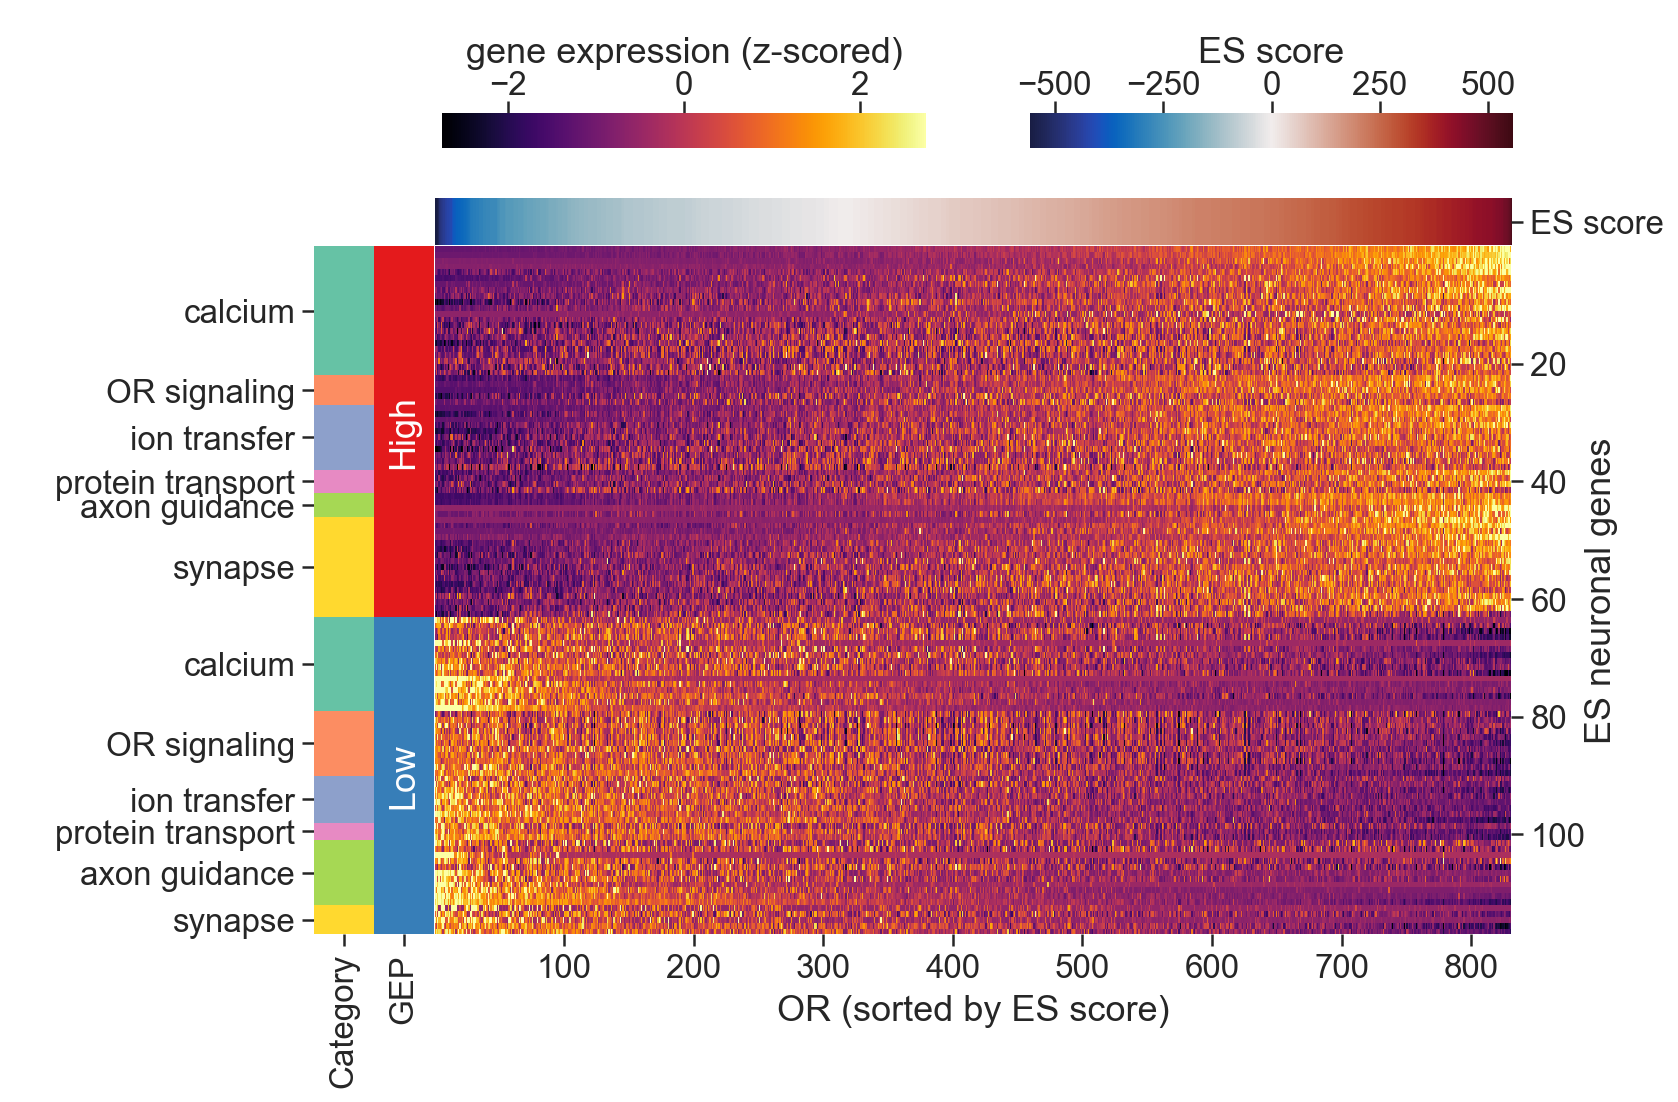

In [13]:
g = sns.clustermap(
    df_func_scale.loc[ess_OR_order][func_order].T,
    figsize=(12, 8),
    row_cluster=False,
    col_cluster=False,
    col_colors=df_cols,
    row_colors=gene_anno,
    cmap="inferno",
    vmin=-2.75,
    vmax=2.75,
    yticklabels=False,
    xticklabels=False,
    colors_ratio=(0.04, 0.051),
    cbar_pos=(0.27, 0.85, 0.28, 0.03),
    cbar_kws={"label": rf"gene expression (z-scored)", "orientation": "horizontal"},
)
top_cbar(g.ax_cbar)
g.ax_row_colors.set_yticks(ticks)
g.ax_row_colors.set_yticklabels(cats * 2)

xt = np.round(np.arange(len(ess_OR_order), step=100)[1:], 2)
g.ax_heatmap.set_xticks(xt)
g.ax_heatmap.set_xticklabels(xt)
g.ax_heatmap.set_xlabel(f"OR (sorted by ES score)", labelpad=5)

g.ax_row_colors.set_yticks(ticks)
g.ax_row_colors.set_yticklabels(cats * 2, rotation=0)

yt = np.round(np.arange(len(func_order), step=20)[1:], 2)
g.ax_heatmap.set_yticks(yt)
g.ax_heatmap.set_yticklabels(yt)
g.ax_heatmap.set_ylabel("ES neuronal genes", labelpad=0)

for v, t in zip((0.731, 0.231), ("High", "Low")):
    g.ax_row_colors.text(
        0.75,
        v,
        t,
        transform=g.ax_row_colors.transAxes,
        fontdict={"color": "w", "rotation": 90},
        va="center",
        ha="center",
    )

ess = df_mean[["ES_score"]].loc[ess_OR_order]
ess_max = np.abs(ess).max()
# add new colormap on top of old one to get image for legend
g.ax_col_colors.set_visible(False)
new_ax = g.fig.add_axes(g.ax_col_colors.get_position())
im = new_ax.imshow(
    ess.T, aspect="auto", vmin=-1 * ess_max, vmax=ess_max, cmap="cmo.balance"
)
new_ax.set_yticks([0])
new_ax.yaxis.tick_right()
new_ax.set_yticklabels(["ES score"])
for s in ["left", "top", "bottom", "right"]:
    new_ax.spines[s].set_visible(False)
new_ax.set_xticks([])

ess_cb_ax = g.fig.add_axes([0.61, 0.85, 0.28, 0.03])
cbar = g.fig.colorbar(im, cax=ess_cb_ax, orientation="horizontal")
cbar.outline.set_linewidth(0)
top_cbar(ess_cb_ax)
cbar.set_label("ES score")
cbar.set_ticks(mpl.ticker.MultipleLocator(250))

## Correlations between high and low GEP associated genes 

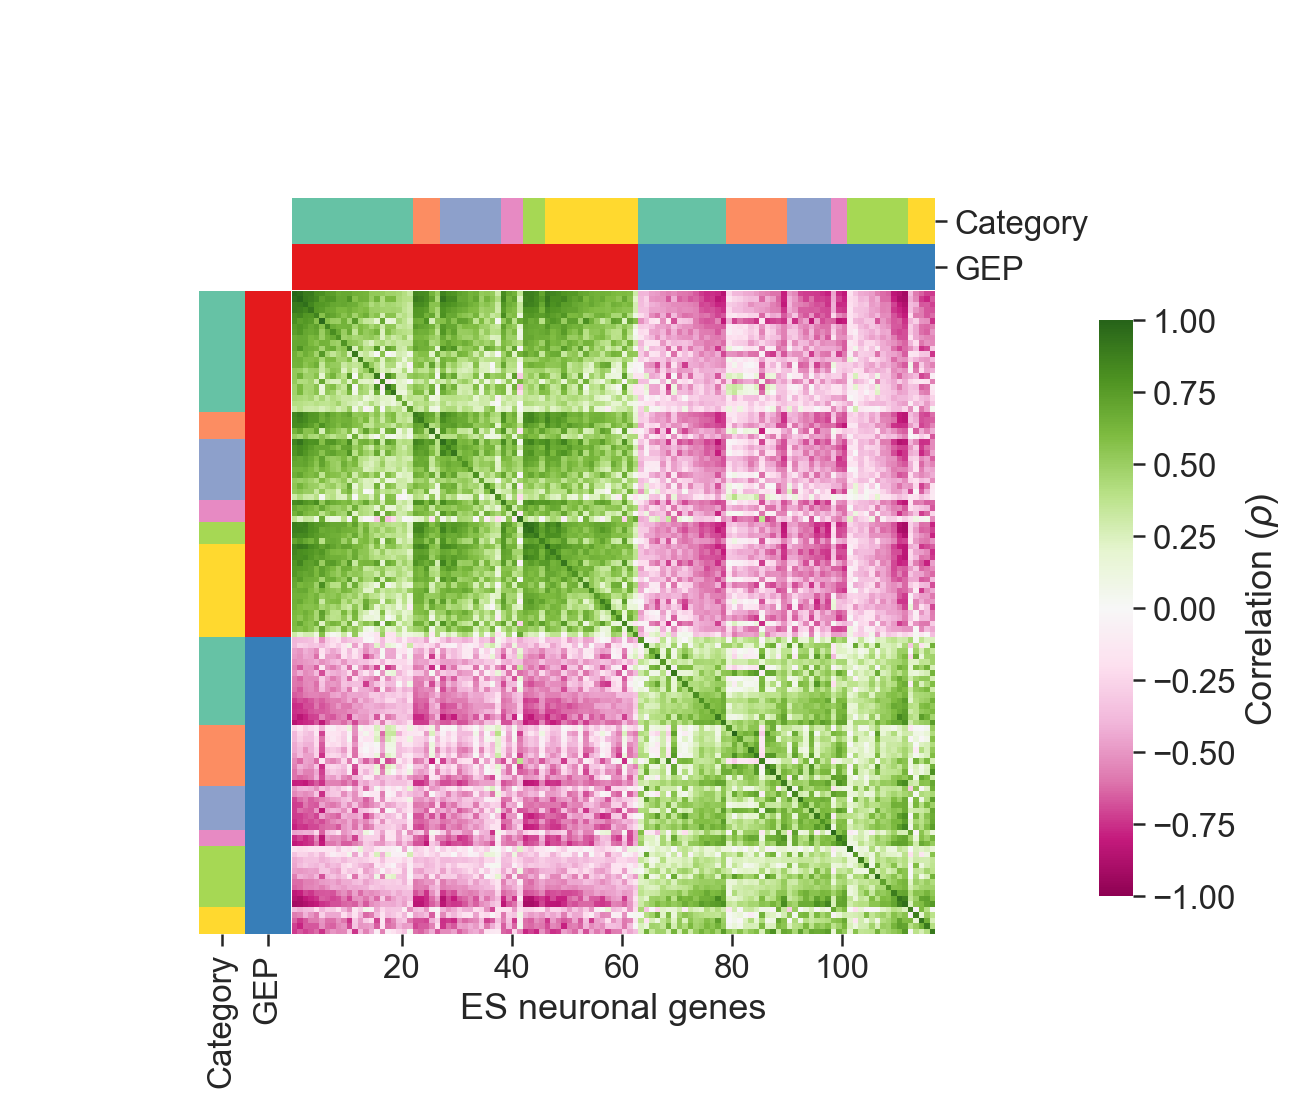

In [14]:
# correlation between ES neuronal genes
g = sns.clustermap(
    df_corr,
    figsize=(8, 8),
    row_cluster=False,
    col_cluster=False,
    row_colors=gene_anno,
    col_colors=gene_anno,
    cmap="PiYG",
    vmin=-1,
    vmax=1,
    cbar_pos=(0.975, 0.2, 0.03, 0.5),
    cbar_kws={"label": rf"Correlation ($\rho$)"},
    xticklabels=False,
    yticklabels=False,
    colors_ratio=(0.05, 0.05),
    rasterized=True
)

yt = np.round(np.arange(len(func_order), step=20)[1:], 2)
g.ax_heatmap.set_xticks(yt)
g.ax_heatmap.set_xticklabels(yt)
g.ax_heatmap.set_xlabel("ES neuronal genes");

Text(0, 0.5, 'Correlation')

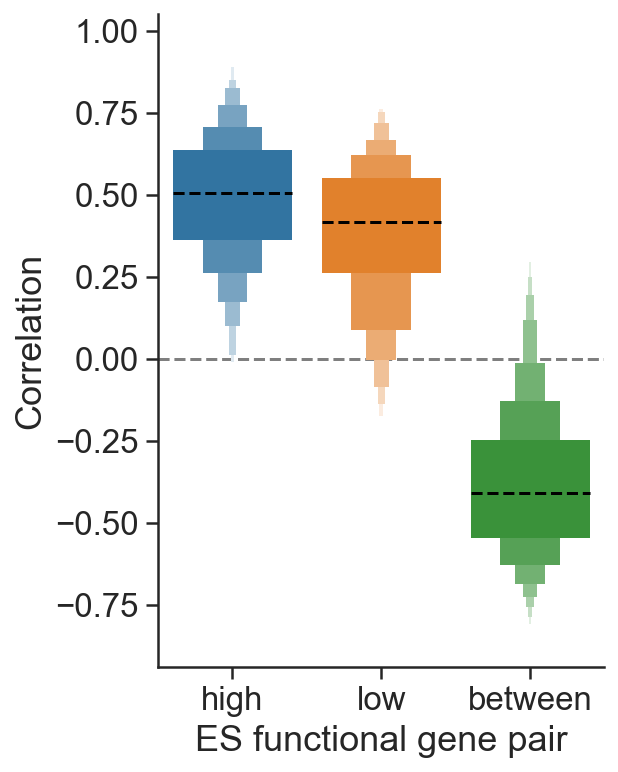

In [15]:
# summarize, only for pairs of functional genes

def row_func(d):
    gep_mapping = df_func_keep.gep.to_dict()
    x = gep_mapping[d.row]
    if x == gep_mapping[d.col]:
        return x
    else:
        return "between"
    
df_corr_nan = df_corr.where(np.triu(np.ones(df_corr.shape), 1).astype(bool))
df_corr_stack = df_corr_nan.stack().reset_index()
df_corr_stack.columns = ["row", "col", "corr"]
df_corr_stack['kind'] = df_corr_stack.apply(row_func, axis=1)

fig, ax = plt.subplots(figsize=(4, 6))
# subset only pairs of functional genes
df_plot = df_corr_stack[
    df_corr_stack.row.isin(pred_genes) & df_corr_stack.col.isin(pred_genes)
]
sns.boxenplot(data=df_plot, x="kind", y="corr", order=["high", "low", "between"])
viz.update_boxen(ax)
ax.axhline(0, ls="--", color="k", alpha=0.5, zorder=-5)
sns.despine()
ax.set_xlabel("ES functional gene pair")
ax.set_ylabel("Correlation")

## Expression of high and low GEP associated functional genes as a function of ES score

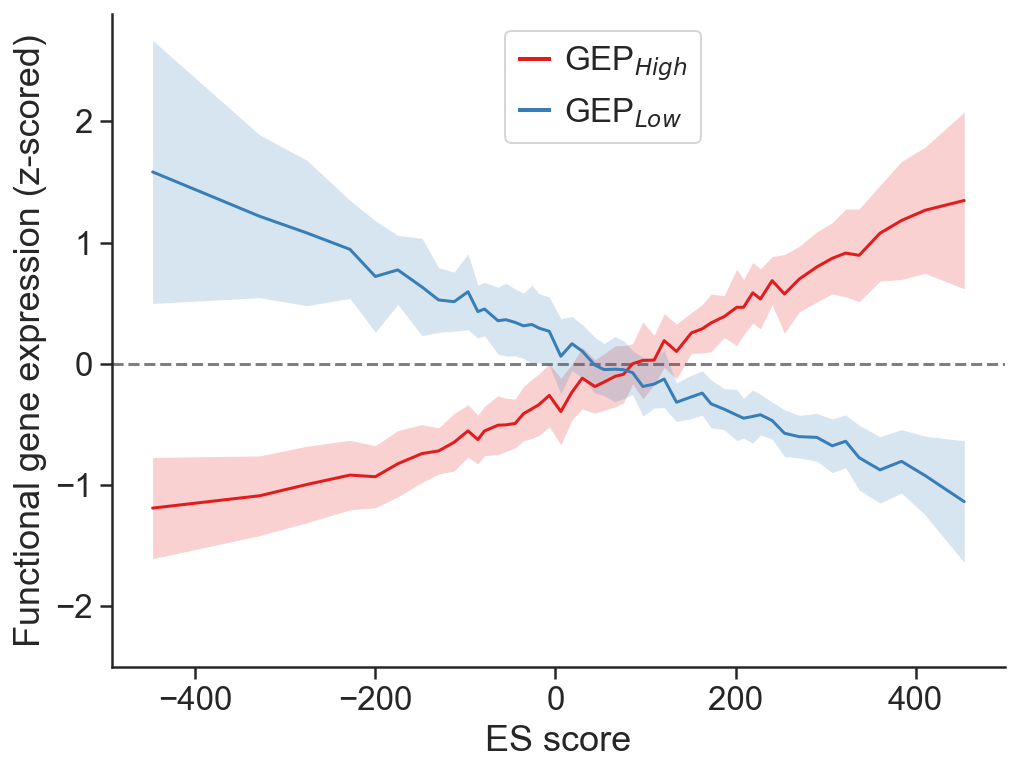

In [16]:
qcats = pd.qcut(df_mean["ES_score"], 50)
glabs = []
for n in ("High", "Low"):
    glabs.append(f"GEP$_{{{n}}}$")
fig, ax = plt.subplots(figsize=(8, 6))
GEPs = df_func_keep.gep.unique()
for i, gep in enumerate(GEPs):
    # mean z-scored functional gene expression for each ES score bin
    df_melt = (
        df_func_scale[df_func_pred.index[df_func_pred.gep == gep]]
        .join(df_mean["ES_score"])
        .groupby(qcats)
        .mean()
        .melt(id_vars=["ES_score"])
    )
    sns.lineplot(
        data=df_melt,
        x="ES_score",
        y="value",
        ci="sd",
        ax=ax,
        err_kws={"lw": 0},
        color=plt.cm.Set1(i),
        label=glabs[i],
        lw=1.5
    )
ax.axhline(0, ls="--", alpha=0.5, color="k", zorder=-1)
sns.despine()
ax.set_xlabel("ES score")
leg = ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.55, 1),
    handlelength=1,
    labelspacing=0.4,
    handletextpad=0.4,
)
for lh in leg.legendHandles:
    lh.set_linewidth(2)
    lh.set_solid_capstyle("butt")
ax.set_ylim(-2.5, None)
ax.set_ylabel("Functional gene expression (z-scored)");